# Cluster Experiments
After the data has been prepared (one entry per user with the userId and percentage of each genre he has watched) and transformed (pca, tsne) several clustering algorithms are tried (with hyper parameter tuning).  
The results of the clustering are ealuated visually based on plotting the transformed data and by manually having a look at the average percentage of watched genres in the different clusters.

In [22]:
# change used width of browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [48]:
# import packages
import pandas as pd
import re
# import seaborn as sb
import matplotlib.pyplot as plt
# import datetime
# import json
# from sklearn.manifold import TSNE as TSNE
from sklearn.cluster import DBSCAN
# import KMeans
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [24]:
# pip install https://github.com/scikit-learn-contrib/scikit-learn-extra/archive/master.zip
from sklearn_extra.cluster import KMedoids

# 1. Load Data

In [54]:
df_joined = pd.read_csv("userclusterdata.csv")
display(df_joined.head(3))

,userId,War,Drama,Western,Thriller,Documentary,Science Fiction,Comedy,History,Music,...,TV Movie,Mystery,Animation,Foreign,Adventure,Romance,Family,Horror,Crime,Action
0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
df_tsne = pd.read_csv("tsne_allgenres.csv",header=None)
df_tsne["0"] = df_tsne[0]
df_tsne["1"] = df_tsne[1]
df_pca = pd.read_csv("pca_allgenres.csv",header=None)
df_pca["0"] = df_pca[0]
df_pca["1"] = df_pca[1]

# 2. Cluster Experiments

## 2.1 KMeans

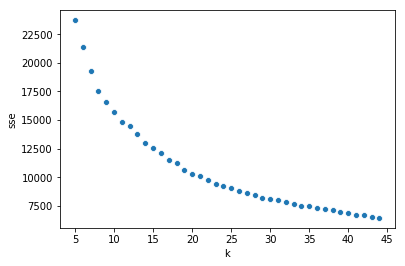

In [58]:
# find the best number of clusters through optimizing the SSE value
df_sse = pd.DataFrame(columns=["k", "sse"])
for i in range(5,45):

    # create the clusterer
    estimator = KMeans(n_clusters = i)
    
    # create the clustering
    clusters = estimator.fit(df_joined.drop(columns="userId"))
    cluster_ids = estimator.predict(df_joined.drop(columns="userId"))
    
    df_sse = df_sse.append({"k": i,
                           "sse": clusters.inertia_}, ignore_index=True)
#     print(" SSE: " + str(clusters.inertia_))
sb.scatterplot(x="k", y="sse",data=df_sse)

In [185]:
# evaluation with silhouette score, runs forever...
# source: https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion
from sklearn.metrics import silhouette_score
for n_cluster in range(7, 10):
    kmeans = KMeans(n_clusters=n_cluster).fit(df_joined.drop(columns="userId"))
    label = kmeans.labels_
    sil_coeff = silhouette_score(df_joined.drop(columns="userId"), label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=7, The Silhouette Coefficient is 0.29261764009427293
For n_clusters=8, The Silhouette Coefficient is 0.32537052656412163
For n_clusters=9, The Silhouette Coefficient is 0.3190656474809759


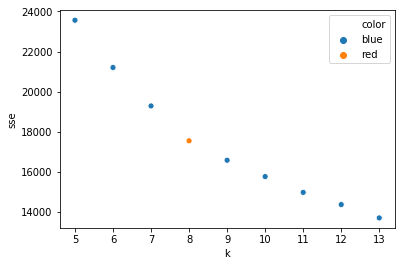

In [194]:
# re plot the sse graph with the chosen k highlighted
df_sse = pd.DataFrame(columns=["k", "sse"])
for i in range(5,14):

    # create the clusterer
    estimator = KMeans(n_clusters = i)
    
    # create the clustering
    clusters = estimator.fit(df_joined.drop(columns="userId"))
    cluster_ids = estimator.predict(df_joined.drop(columns="userId"))
    
    df_sse = df_sse.append({"k": i,
                           "sse": clusters.inertia_}, ignore_index=True)
#     print(" SSE: " + str(clusters.inertia_))
df_sse["color"] = "blue"
df_sse.loc[df_sse["k"] == 8.0,"color"] = "red"
sb.scatterplot(x="k", y="sse",data=df_sse, hue="color")

In [187]:
kmeans_chosen_k = 8

In accordance with the <i>Elbow-Method</i> k=8 is chosen. Even though the SSE improves for higher ks, the improvement is not significant.  
source: https://medium.com/towards-artificial-intelligence/get-the-optimal-k-in-k-means-clustering-d45b5b8a4315

In [188]:
# run clustering with chosen k
# create the clusterer
estimator = KMeans(n_clusters = kmeans_chosen_k)

# create the clustering
clusters = estimator.fit(df_joined.drop(columns="userId"))
cluster_ids = estimator.predict(df_joined.drop(columns="userId"))

df_pca["clusterids"] = cluster_ids
df_tsne["clusterids"] = cluster_ids

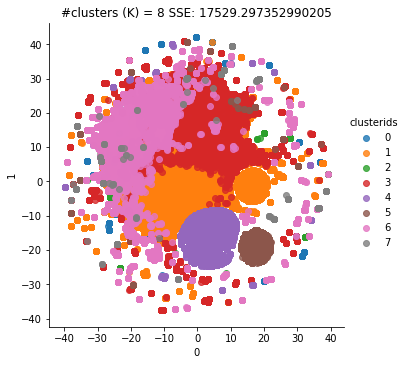

In [189]:
# plot the clusters on the transformed tsne data with k = (best number of clusters)
facet = sb.lmplot(data=df_tsne, x="0", y="1", hue="clusterids", fit_reg=False, legend=True, legend_out=True)#, palette="muted"
facet.set(title="#clusters (K) = {}".format(kmeans_chosen_k) + " SSE: " + str(clusters.inertia_))
plt.show()

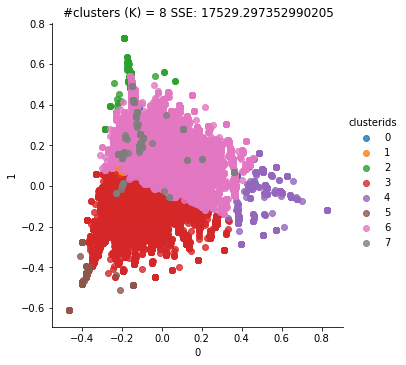

In [190]:
# plot the clusters on the transformed pca data with k = (best number of clusters)
facet = sb.lmplot(data=df_pca, x="0", y="1", hue="clusterids", fit_reg=False, legend=True, legend_out=True)#, palette="muted"
facet.set(title="#clusters (K) = {}".format(kmeans_chosen_k) + " SSE: " + str(clusters.inertia_))
plt.show()

In [191]:
# check cluster sizes
df_temp = df_joined.drop(columns="userId")
df_temp["clusterid"] = cluster_ids
df_temp.groupby("clusterid").count()

,War,Drama,Western,Thriller,Documentary,Science Fiction,Comedy,History,Music,Fantasy,TV Movie,Mystery,Animation,Foreign,Adventure,Romance,Family,Horror,Crime,Action
clusterid,,,,,,,,,,,,,,,,,,,,
0,4946,4946,4946,4946,4946,4946,4946,4946,4946,4946,4946,4946,4946,4946,4946,4946,4946,4946,4946,4946
1,68437,68437,68437,68437,68437,68437,68437,68437,68437,68437,68437,68437,68437,68437,68437,68437,68437,68437,68437,68437
2,5456,5456,5456,5456,5456,5456,5456,5456,5456,5456,5456,5456,5456,5456,5456,5456,5456,5456,5456,5456
3,38331,38331,38331,38331,38331,38331,38331,38331,38331,38331,38331,38331,38331,38331,38331,38331,38331,38331,38331,38331
4,22617,22617,22617,22617,22617,22617,22617,22617,22617,22617,22617,22617,22617,22617,22617,22617,22617,22617,22617,22617
5,8091,8091,8091,8091,8091,8091,8091,8091,8091,8091,8091,8091,8091,8091,8091,8091,8091,8091,8091,8091
6,26278,26278,26278,26278,26278,26278,26278,26278,26278,26278,26278,26278,26278,26278,26278,26278,26278,26278,26278,26278
7,5753,5753,5753,5753,5753,5753,5753,5753,5753,5753,5753,5753,5753,5753,5753,5753,5753,5753,5753,5753


In [192]:
# get top3 dominating genres in clusters
# https://stackoverflow.com/questions/38955182/find-names-of-top-n-highest-value-columns-in-each-pandas-dataframe-row
df_temp = df_temp.groupby("clusterid").mean()

nlargest = 3
order = np.argsort(-df_temp.values, axis=1)[:, :nlargest]
result = pd.DataFrame(df_temp.columns[order], 
                      columns=['top{}'.format(i) for i in range(1, nlargest+1)],
                      index=df_temp.index)

In [193]:
# check dominating genres in clusters by value
for index, row in result.iterrows():
    temp = pd.DataFrame(columns=[row.top1, row.top2, row.top3])
    temp = df_temp[df_temp.index == index][[row.top1, row.top2, row.top3]]
    display(temp)

,Fantasy,Documentary,Horror
clusterid,,,
0,0.693798,0.257012,0.017279


,Drama,Comedy,Thriller
clusterid,,,
1,0.172409,0.091557,0.063877


,Comedy,Animation,Drama
clusterid,,,
2,0.969514,0.014073,0.004433


,Drama,Documentary,War
clusterid,,,
3,0.418766,0.136182,0.092122


,Documentary,Fantasy,Drama
clusterid,,,
4,0.965239,0.014105,0.007799


,Drama,War,Crime
clusterid,,,
5,0.992293,0.002865,0.001741


,Comedy,Documentary,Animation
clusterid,,,
6,0.31069,0.221865,0.106146


,Animation,Comedy,Documentary
clusterid,,,
7,0.703672,0.196463,0.075948


<b>Insights:</b> 
- generally has a good runtime performance (also compared to other clustering algorithms in our case)
- yields good results with the chosen k value

## 2.2 KMedoids
Unable to run KMedoids on all data. BUT  
- we don't have real outliers anyways  
- the clusters with a sample of 10.000 of the data don't look too different from KMeans with all data  
-> KMeans is the better choice

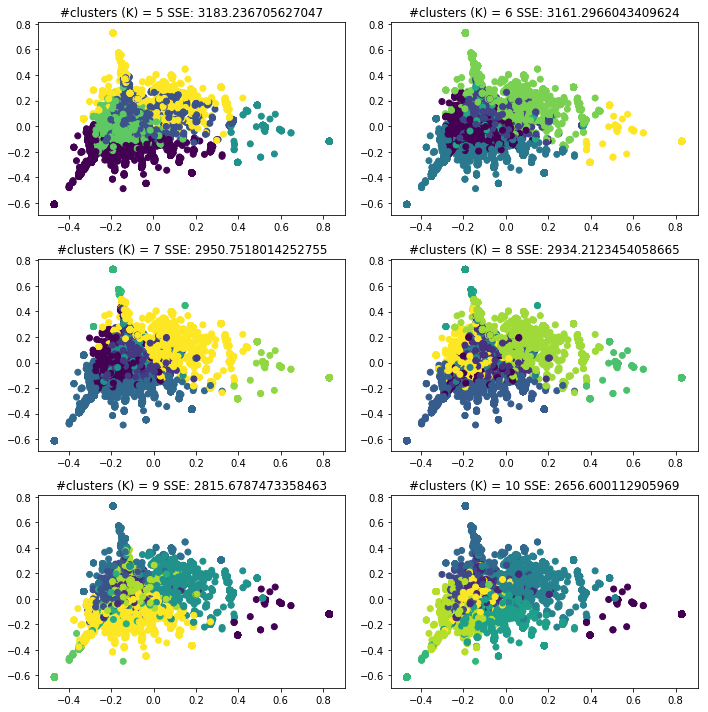

In [13]:
# setup a figure
plt.figure(figsize=(10,10))

# iterate over all values that we want to test for K
a = 1
for i in range(5,11):
    # create the clusterer
    estimator = KMedoids(metric="euclidean", n_clusters=i)
    
    # create the clustering
#     cluster_ids = estimator.fit_predict(df_joined.drop(columns="userId"))
    clusters = estimator.fit(df_joined.drop(columns="userId").head(10000))
    cluster_ids = estimator.predict(df_joined.drop(columns="userId").head(10000))

    # add a subplot
    plt.subplot(3,2,a)
    a = a + 1
    
    # automatically adjust subplot params so that the subplot(s) fits in to the figure area
    plt.tight_layout() 
    
    # setup the labels of the subplot
    plt.title("#clusters (K) = {}".format(i) + " SSE: " + str(clusters.inertia_))
#     plt.xlabel('ItemsBought')
#     plt.ylabel('ItemsReturned')
    
    # create the scatter plot
    plt.scatter(df_tsne.head(10000)[0],df_tsne.head(10000)[1], c=cluster_ids)
#     plt.scatter(df_tsne[0],df_tsne[1], c=cluster_ids)
        
plt.show()

## 2.3 Agglomerative Clustering
Trying to run agglomerative clustering on all untransformed data immediatley results in a memory error.  
It is also not possible to run it on the transformed data even though the dimensionality is reduced.

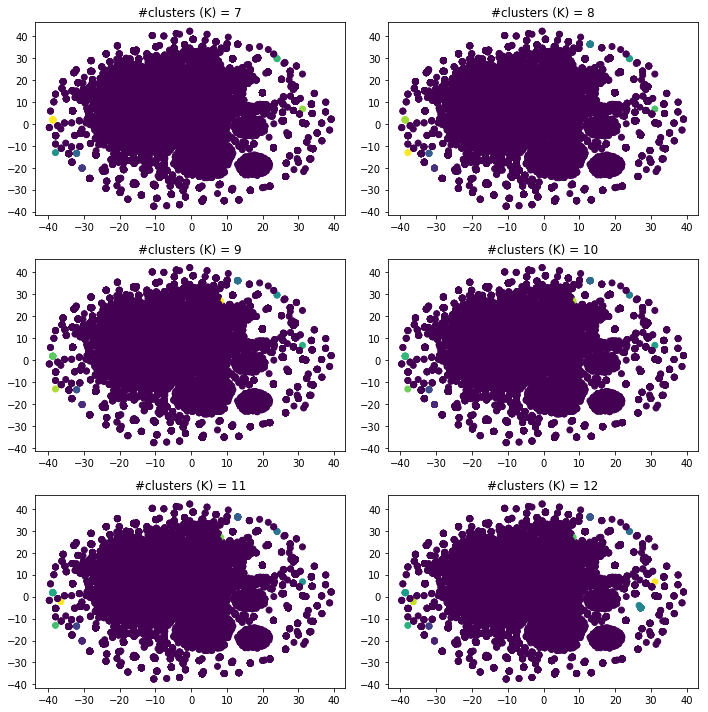

In [184]:
# setup a figure
plt.figure(figsize=(10,10))

# iterate over all values that we want to test for K
a = 1
for i in range(7,13):
    # create the clusterer
    estimator = AgglomerativeClustering(n_clusters = i, linkage='single', affinity='euclidean')
    
    # create the clustering
    cluster_ids = estimator.fit_predict(df_joined.drop(columns="userId").head(10000))

    # add a subplot
    plt.subplot(3,2,a)
    a = a + 1
    
    # automatically adjust subplot params so that the subplot(s) fits in to the figure area
    plt.tight_layout() 
    
    # setup the labels of the subplot
    plt.title("#clusters (K) = {}".format(i))
    
    # create the scatter plot
#     plt.scatter(df_pca["0"],df_pca["1"], c=cluster_ids)
    plt.scatter(df_tsne["0"].head(10000),df_tsne["1"].head(10000), c=cluster_ids)
        
plt.show()

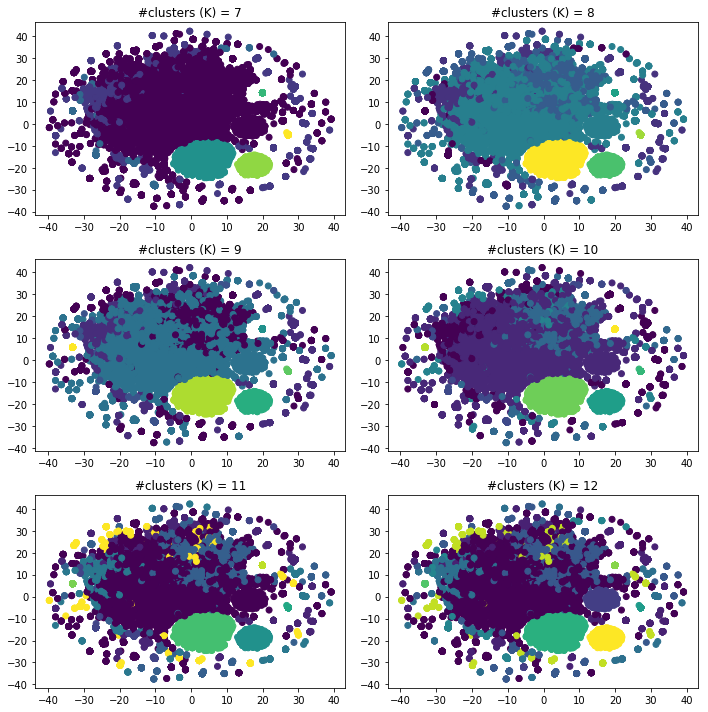

In [181]:
# setup a figure
plt.figure(figsize=(10,10))

# iterate over all values that we want to test for K
a = 1
for i in range(7,13):
    # create the clusterer
    estimator = AgglomerativeClustering(n_clusters = i, linkage='ward', affinity='euclidean')
    
    # create the clustering
    cluster_ids = estimator.fit_predict(df_joined.drop(columns="userId").head(10000))

    # add a subplot
    plt.subplot(3,2,a)
    a = a + 1
    
    # automatically adjust subplot params so that the subplot(s) fits in to the figure area
    plt.tight_layout() 
    
    # setup the labels of the subplot
    plt.title("#clusters (K) = {}".format(i))
    
    # create the scatter plot
#     plt.scatter(df_pca["0"],df_pca["1"], c=cluster_ids)
    plt.scatter(df_tsne["0"].head(10000),df_tsne["1"].head(10000), c=cluster_ids)
        
plt.show()

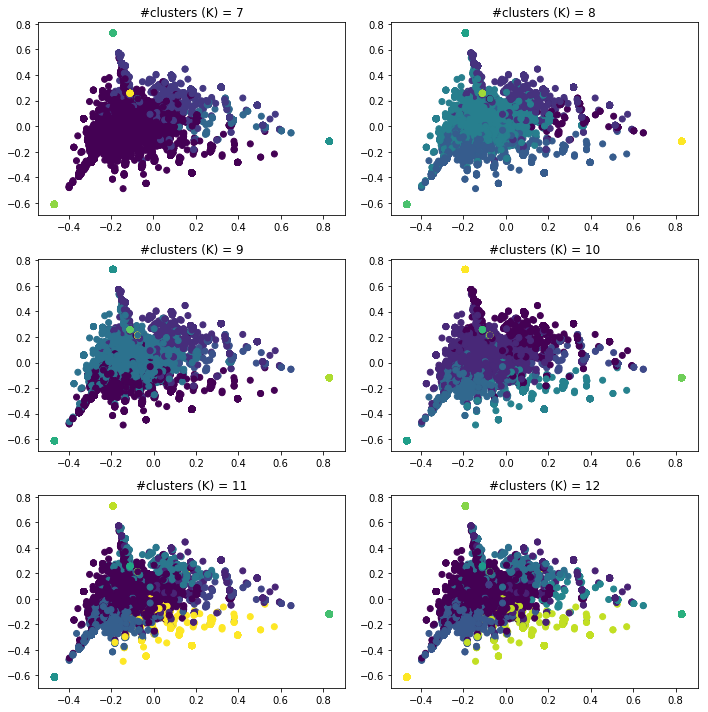

In [195]:
# setup a figure
plt.figure(figsize=(10,10))

# iterate over all values that we want to test for K
a = 1
for i in range(7,13):
    # create the clusterer
    estimator = AgglomerativeClustering(n_clusters = i, linkage='ward', affinity='euclidean')
    
    # create the clustering
    cluster_ids = estimator.fit_predict(df_joined.drop(columns="userId").head(10000))

    # add a subplot
    plt.subplot(3,2,a)
    a = a + 1
    
    # automatically adjust subplot params so that the subplot(s) fits in to the figure area
    plt.tight_layout() 
    
    # setup the labels of the subplot
    plt.title("#clusters (K) = {}".format(i))
    
    # create the scatter plot
    plt.scatter(df_pca["0"].head(10000),df_pca["1"].head(10000), c=cluster_ids)
#     plt.scatter(df_tsne["0"].head(10000),df_tsne["1"].head(10000), c=cluster_ids)
        
plt.show()

<b>Insights:</b>
- It doesn't work well with linkage=single at all.  
- works better with linkage=ward, but kmeans still returns clearer clusters (when e.g. comparing k = 9)
- here, only with k = 12 the third "bubble" is also a seperate cluster
Since its not possible to run it on all data and the difference to kmeans doesn't appear to be very large we prefer kmeans

## 2.4 DBSCAN
doesn't work well on a subset of the data, unable to run on all data

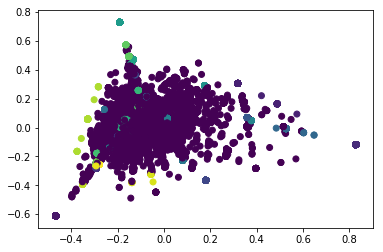

In [15]:
# create the clusterer
clusterer = DBSCAN(min_samples=25, eps=0.02, metric='cosine')
# create the clusters
clusters = clusterer.fit(df_joined.drop(columns="userId").head(10000))

plt.scatter(df_tsne.head(10000)[0],df_tsne.head(10000)[1] ,c=clusters.labels_)
plt.show()

# 3. Add Cluster IDs to Ratings
The cluster IDs can then be used to calculate the average rating of a cluster per movie.  
These ratings are calculated for the whole movie dataset, then the training part of the dataset is used to train a model per cluster (clusterrating as target variable) and the test part to evaluate these models.

In [16]:
# load ratings
df_ratings = pd.read_csv("the-movies-dataset/ratings.csv")

In [17]:
# add cluster ID to ratings.csv
# df_ratings[df_ratings["userId"] == df_joined["userId"]]

In [18]:
# calculate average cluster ratings for movies

## 4. Apply Clustering Modle to movies 
Each movie is thereby clustered as well, that way we can find the ratings from the <i>target user</i> group and calculate the mean rating in the target audience.